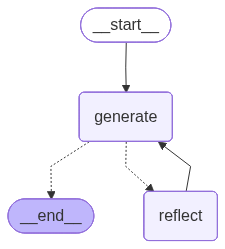

In [1]:
from typing import Annotated, TypedDict
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, SystemMessage

from langchain_ollama import ChatOllama

from langgraph.graph import START, END, StateGraph
from langgraph.graph import add_messages

model = ChatOllama(model="llama3.1")

class State(TypedDict):
    messages: Annotated[BaseMessage, add_messages]

generate_prompt = SystemMessage("""You are an essay assistant tasked with writingm excellent 3-paragraph essays."""
                                """Generate the best possible essay for the users request. If the user provides critique, respond with a revised version of your previous attempts""")

def generate(state:State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages":[answer]}

reflection_prompt = SystemMessage("""You are a teacher grading an essay submission. Generate critique and
                                  recommendations for the users submission. Provide detailed recommendations, including requests for length, depth, style, etc.""")

def reflect(state:State) -> State:
    cls_map ={AIMessage: HumanMessage , HumanMessage:AIMessage}
    translated = [reflection_prompt, state["messages"][0]] + \
        [cls_map[msg.__class__](content=msg.content) for msg in state["messages"][1:]]
    answer = model.invoke(translated)
    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state:State) -> State:
    if len(state["messages"]) > 6:
        return END
    else:
        return "reflect"
    
# Build the graph
builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue,{"reflect": "reflect", END: END})
builder.add_edge("reflect", "generate")

graph = builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Example usage
initial_state = {
    "messages": [
        HumanMessage(
            content="Write an essay about the relevance of 'The Little Prince' today."
        )
    ]
}

# Run the graph
for output in graph.stream(initial_state):
    message_type = "generate" if "generate" in output else "reflect"
    print("\nNew message:", output[message_type]
          ["messages"][-1].content, "...")


New message: Here is a three-paragraph essay on the relevance of "The Little Prince" by Antoine de Saint-Exupéry:

Published in 1943, Antoine de Saint-Exupéry's novella "The Little Prince" has captivated readers worldwide with its poignant tale of love, loss, and self-discovery. On the surface, this small yet profound book appears to be a charming story for children, but its themes and messages are surprisingly relevant today. As we navigate the complexities of modern life, Saint-Exupéry's timeless wisdom offers a much-needed antidote to our increasingly fast-paced and isolating world.

One of the most striking aspects of "The Little Prince" is its exploration of the human relationship with technology and social media. The little prince's beloved rose is a symbol of love and connection, but it also serves as a commentary on our modern obsession with screens and virtual relationships. In today's era of constant connectivity, we often find ourselves more isolated than ever before, surro

# Subgraphs


In [ ]:
from langgraph.graph import START, StateGraph
from typing import TypedDict

class State(TypedDict):
    foo : str
class SubgraphState(TypedDict):
    foo: str
    bar: str
def subgraph_node(state: SubgraphState):
    return {"foo": state["foo"] + "bar"}
subgraph_builder =StateGraph(SubgraphState)
subgraph_builder.add_node

# Supervisor Architecture

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "EleutherAI/gpt-j-6B"  # Fully open, no auth required

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

input_text = "Hello, how are you today?"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
